# Bay Wheels Bike Data Exploration
## by Mrunal Karkhanis

## Preliminary Wrangling

> The Baywheels Bike Trip Data contains 

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [3]:
import urllib
import requests
import os
import io
import xml.etree.ElementTree as ET 
import zipfile
from glob import glob

def loadXML(): 
  
    # url of data
    url = 'https://s3.amazonaws.com/baywheels-data'
  
    # creating HTTP response object from given url 
    response = requests.get(url) 
  
    # saving the xml file 
    with open('baywheels-data.xml', 'wb') as f: 
        f.write(response.content) 

In [4]:
def parse_XML(data): 
    # create Element Tree object
    tree = ET.parse(data)
    # get root element 
    root = tree.getroot() 
    # create list to store file names
    filenames = [] 
    # obtain child nodes of Element Tree
    children = root.getchildren()
    for child in children:
        for element in child:
            if (element.tag) == '{http://s3.amazonaws.com/doc/2006-03-01/}Key':
                name = element.text.encode('utf8') 
                # We use find method to exclude the index.html file
                if name.find('.html') == -1:
                    filenames.append(name)
    return filenames

In [5]:
def createURL(name):
    url_list = []
    for i in name:
        url_list.append("https://s3.amazonaws.com/baywheels-data/"+i)
    return url_list

In [6]:
# Make directory if it doesn't already exist
folder_name = 'baywheels_ride_data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [7]:
def downloadfile(urllist):
    for url in urllist:
        if url.find('.zip') == -1:
            response = requests.get(url)
            with open(os.path.join(folder_name,url.split('/')[-1]),mode ='wb') as file:
                file.write(response.content)
        else:
            response = requests.get(url)
            csv = zipfile.ZipFile(io.BytesIO(response.content))
            csv.extractall(path = '/Users/mkarkhan/anaconda2/baywheels_ride_data')

In [8]:
def filetodf():
    listitem = []
    for filename in glob('/Users/mkarkhan/anaconda2/baywheels_ride_data/'+'*.csv'):
        with open(filename, 'r') as f:
            df = pd.read_csv(f)
            listitem.append(df)
    bikedata_df = pd.concat(listitem, axis=0, ignore_index=True, sort=True)
    return bikedata_df

In [9]:
def main():
    # load xml from web to a file
    loadXML()
    # parse xml file
    filenames = parse_XML('baywheels-data.xml')
    # build urls from file names
    filenames_url = createURL(filenames)
    # doanload csv files to folder using urls
    downloadfile(filenames_url)
    # imports data from csv files in folder to dataframe
    bikedata_df = filetodf()
    return bikedata_df

In [10]:
bikedata_df = main()

/Users/mkarkhan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  if __name__ == '__main__':
/Users/mkarkhan/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
bikedata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3628260 entries, 0 to 3628259
Data columns (total 17 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   object
member_birth_year          float64
member_gender              object
rental_access_method       object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 object
user_type                  object
dtypes: float64(7), int64(2), object(8)
memory usage: 470.6+ MB


In [12]:
# Check if any duplicates exist
bikedata_df.duplicated().sum()

0

In [13]:
# Check if missing values exist
bikedata_df.isna().sum()

bike_id                          0
bike_share_for_all_trip     523593
duration_sec                     0
end_station_id               14778
end_station_latitude             0
end_station_longitude            0
end_station_name             14778
end_time                         0
member_birth_year           245772
member_gender               245118
rental_access_method       3624367
start_station_id             14676
start_station_latitude           0
start_station_longitude          0
start_station_name           14676
start_time                       0
user_type                        0
dtype: int64

### Data Assessing:

Quality Issues:
1. start_time and end_time should be datetime datatype
2. start_station_id and end_station_id should be object datatype
3. member_birth_year should be integer datatype
4. Calculate age of member and create new column for it using member_birth_year
5. Calculate distance between stations using latitude and longitude points.

### Data Cleaning

In [156]:
# Create copy of the data before we clean it
bikedata_df_copy = bikedata_df.copy()

#### Define:

Convert start_time and endtime to datetime datatype using to_datetime() function

#### Code:

In [157]:
bikedata_df_copy['start_time'] = pd.to_datetime(bikedata_df_copy.start_time)
bikedata_df_copy['end_time'] = pd.to_datetime(bikedata_df_copy.end_time)

#### Test:

In [158]:
bikedata_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3628260 entries, 0 to 3628259
Data columns (total 17 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   datetime64[ns]
member_birth_year          float64
member_gender              object
rental_access_method       object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
dtypes: datetime64[ns](2), float64(7), int64(2), object(6)
memory usage: 470.6+ MB


#### Define:

Convert start_station_id and end_station_id to object datatype using astype() function

#### Code:

In [159]:
bikedata_df_copy['start_station_id'] = bikedata_df_copy['start_station_id'].astype('object')
bikedata_df_copy['end_station_id'] = bikedata_df_copy['end_station_id'].astype('object')

#### Test

In [160]:
bikedata_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3628260 entries, 0 to 3628259
Data columns (total 17 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             object
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   datetime64[ns]
member_birth_year          float64
member_gender              object
rental_access_method       object
start_station_id           object
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
dtypes: datetime64[ns](2), float64(5), int64(2), object(8)
memory usage: 470.6+ MB


#### Define:

Fill missing values with 0000 using fillna() and convert member_birth_year to int using astype() function

#### Code:

In [161]:
# We fill missing values for member birth year with '0000'
bikedata_df_copy['member_birth_year'] = bikedata_df_copy['member_birth_year'].fillna('0000')
# Convert member birth year to int datatype
bikedata_df_copy['member_birth_year'] = bikedata_df_copy['member_birth_year'].astype('int64')

#### Test:

In [162]:
bikedata_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3628260 entries, 0 to 3628259
Data columns (total 17 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             object
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   datetime64[ns]
member_birth_year          int64
member_gender              object
rental_access_method       object
start_station_id           object
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
dtypes: datetime64[ns](2), float64(4), int64(3), object(8)
memory usage: 470.6+ MB


#### Define:

Calculate age of member by subtracting birth year from current year

#### Code:

In [163]:
bikedata_df_copy['age'] = 2019 - bikedata_df_copy['member_birth_year']

# We replace the age for members whose birth years we do not have with 0
bikedata_df_copy['age'] = bikedata_df_copy['age'].replace(2019,0)

#### Test:

In [164]:
bikedata_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3628260 entries, 0 to 3628259
Data columns (total 18 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             object
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   datetime64[ns]
member_birth_year          int64
member_gender              object
rental_access_method       object
start_station_id           object
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
age                        int64
dtypes: datetime64[ns](2), float64(4), int64(4), object(8)
memory usage: 498.3+ MB


#### Define:

Defined a function to calculate distance between start and end stations using latitude and longitude with the Haversine formula.

Assigned calculated distance to distance column in dataframe

#### Code:

In [165]:
import math
from math import radians, sin, cos, acos

def distfromlatlong(lat_start,lon_start,lat_end,lon_end):
    
    # approximate radius of earth in miles
    R = 3958.8

    dlon = math.radians(lon_end - lon_start)
    dlat = math.radians(lat_end - lat_start)
    
    a = sin(dlat / 2)**2 + cos(lat_start) * cos(lat_end) * sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

In [166]:
bikedata_df_copy['distance'] = bikedata_df_copy.apply(lambda x: distfromlatlong(x['start_station_latitude'], x['start_station_longitude'], x['end_station_latitude'], x['end_station_longitude']), axis=1)

#### Test:

In [167]:
bikedata_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3628260 entries, 0 to 3628259
Data columns (total 19 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             object
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   datetime64[ns]
member_birth_year          int64
member_gender              object
rental_access_method       object
start_station_id           object
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
age                        int64
distance                   float64
dtypes: datetime64[ns](2), float64(5), int64(4), object(8)
memory usage: 525.9+ MB


#### Define:



#### Code:

In [168]:
bikedata_df_copy = bikedata_df_copy.query('end_station_latitude != 0.00000')
bikedata_df_copy = bikedata_df_copy.query('start_station_latitude != 0.00000')

#### Test:

In [169]:
bikedata_df_copy.query('end_station_latitude == 0.00000')

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,rental_access_method,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,distance


In [170]:
bikedata_df_copy.query('start_station_latitude == 0.00000')

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,rental_access_method,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,age,distance


#### Define:

Since 99% of the data is under the age of 65 years, we will exclude bike ride data for users above 65 years of age.

#### Code:

In [171]:
# We can see that 99% of users are under the age of 65 years
bikedata_df_copy['age'].describe(percentiles = [.99])

count    3.628241e+06
mean     3.329310e+01
std      1.348744e+01
min      0.000000e+00
50%      3.300000e+01
99%      6.500000e+01
max      1.410000e+02
Name: age, dtype: float64

In [172]:
bikedata_df_copy = bikedata_df_copy.query('age <= 65')

#### Test:

In [173]:
bikedata_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3594926 entries, 0 to 3628259
Data columns (total 19 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             object
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   datetime64[ns]
member_birth_year          int64
member_gender              object
rental_access_method       object
start_station_id           object
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
age                        int64
distance                   float64
dtypes: datetime64[ns](2), float64(5), int64(4), object(8)
memory usage: 548.5+ MB


#### Define:

The member_gender column has various values for Male, Female and Other such as M, F, O and ?
We will replace M by Male, F by Female and O and ? by Other using the replace function.

#### Code:

In [174]:
bikedata_df_copy['member_gender'] = bikedata_df_copy['member_gender'].replace('M','Male')
bikedata_df_copy['member_gender'] = bikedata_df_copy['member_gender'].replace('F','Female')
bikedata_df_copy['member_gender'] = bikedata_df_copy['member_gender'].replace('O','Other')
bikedata_df_copy['member_gender'] = bikedata_df_copy['member_gender'].replace('?','Other')

#### Test:

In [175]:
bikedata_df_copy['member_gender'].value_counts()

Male      2481873
Female     812975
Other       54960
Name: member_gender, dtype: int64

### What is the structure of your dataset?

> 

### What is/are the main feature(s) of interest in your dataset?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

> <b> Member_Age </b>

Text(0.5,1,'Bike Ride Count by User Age')

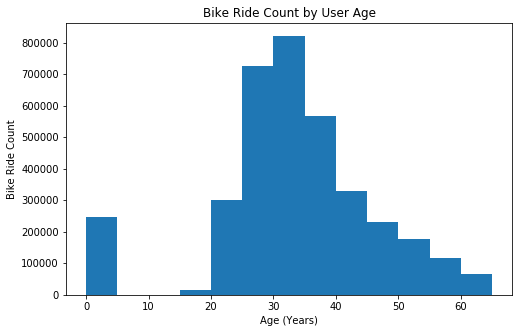

In [176]:
plt.figure(figsize = [8,5])
bin_edges = np.arange(0,bikedata_df_copy['age'].max()+1,5)
plt.hist(data = bikedata_df_copy, x='age', bins=bin_edges)
plt.xlabel('Age (Years)')
plt.ylabel('Bike Ride Count')
plt.title('Bike Ride Count by User Age', fontsize = 12)


The average mean age of users is 33 years. We observe that maximum users are in the age group of 30-35 years which concurs with our mean. The little spike we see at 0 years are those users whose Member_birth_year was not available and so their age was set to 0 years. We chose to ignore this spike.

> <b> Member Gender </b>

Text(0.5,1,'Bike Ride Count by User Gender')

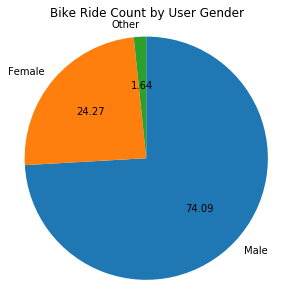

In [177]:
plt.figure(figsize = [8,5])
sorted_counts = bikedata_df_copy['member_gender'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90,
        counterclock = False, autopct = '%.2f')
plt.axis('square')
plt.title('Bike Ride Count by User Gender', fontsize = 12)

We observe that a majority of our users are Males, more accurately 74.09% as compared to Females (24.27%). The Other gender counts rides taken by users that did not share their gender with us or did not confirm to either Male or Female.

In [245]:
# We extract year, month, weekday and hour from the start_time variable to 
bikedata_df_copy['year'] = bikedata_df_copy['start_time'].dt.year
bikedata_df_copy['month'] = bikedata_df_copy['start_time'].dt.month
bikedata_df_copy['weekday'] = bikedata_df_copy['start_time'].dt.weekday
bikedata_df_copy['hour'] = bikedata_df_copy['start_time'].dt.hour

> <b> Bike Ride Data By Year </b>

Text(0.5,1,'Bike Ride Count by Year')

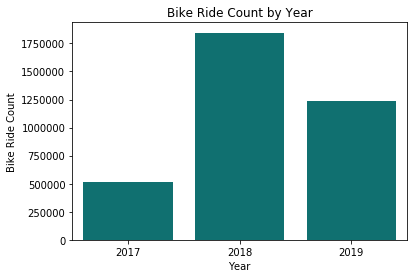

In [179]:
plt.figure(figsize = [6,4])
sb.countplot(data = bikedata_df_copy, x = 'year', color = 'teal')
plt.xlabel('Year')
plt.ylabel('Bike Ride Count')
plt.title('Bike Ride Count by Year', fontsize = 12)


We observe that most rides were taken in the year 2018. However we still do not have complete data for 2019, so this is true only for the current data.

> <b> Bike Ride Data by Month </b>

([<matplotlib.axis.XTick at 0x1a712a4a50>,
 <a list of 12 Text xticklabel objects>)

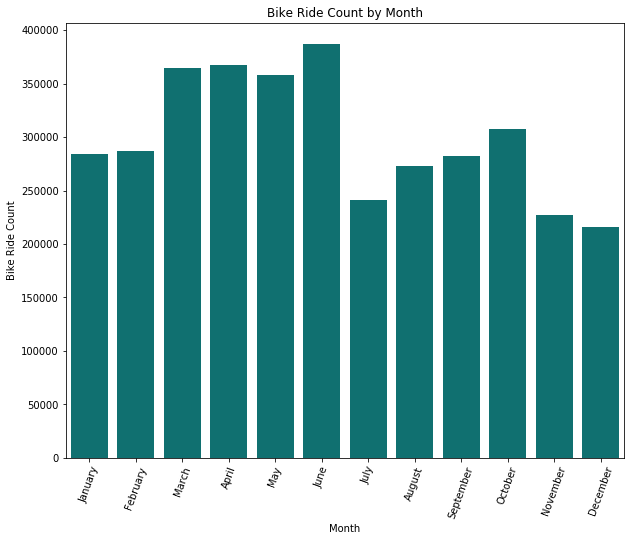

In [180]:
plt.figure(figsize = [10,8])
sb.countplot(data = bikedata_df_copy, x = 'month', color = 'teal')
plt.xlabel('Month')
plt.ylabel('Bike Ride Count')
plt.title('Bike Ride Count by Month', fontsize = 12)
plt.xticks(np.arange(0,12,1),['January','February','March','April','May','June','July','August','September','October','November','December'], rotation = 70)


Most rides are taken by users in the month of June, followed by April, March and May. 
This is the time when it begins to get warmer so the increased bike rides are normal. Another small spike is observed in October which is Fall season. As the temperature goes down a little, maybe users begin riding again untill it gets colder.

> <b> Bike Ride Data by Weekday </b>

([<matplotlib.axis.XTick at 0x1a7555b0d0>,
 <a list of 7 Text xticklabel objects>)

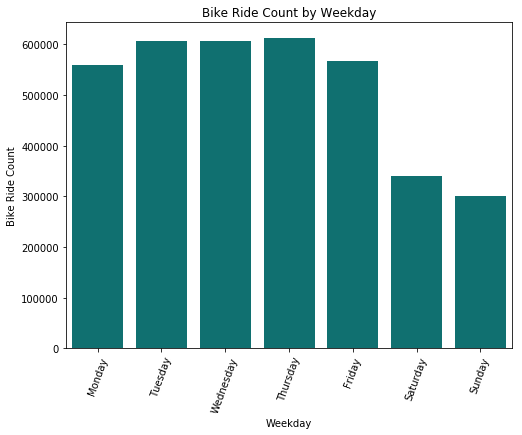

In [181]:
plt.figure(figsize = [8,6])
sb.countplot(data = bikedata_df_copy, x = 'weekday', color = 'teal')
plt.xlabel('Weekday')
plt.ylabel('Bike Ride Count')
plt.title('Bike Ride Count by Weekday', fontsize = 12)
plt.xticks(np.arange(0,7,1),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation = 70)


We observe that most rides are taken on Thursday followed by other days during the week. This reiterates te fact that most bike rides are undertaken to head to work/school and not for leisure

> <b> Bike Ride Data by Weekday </b>

([<matplotlib.axis.XTick at 0x1a75e6a9d0>,
 <a list of 24 Text xticklabel objects>)

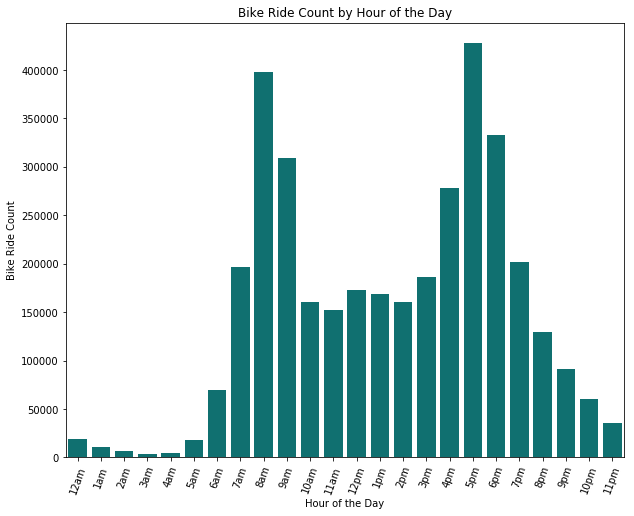

In [182]:
plt.figure(figsize = [10,8])
sb.countplot(data = bikedata_df_copy, x = 'hour', color = 'teal')
plt.xlabel('Hour of the Day')
plt.ylabel('Bike Ride Count')
plt.title('Bike Ride Count by Hour of the Day', fontsize = 12)
plt.xticks(np.arange(0,24,1),['12am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm'], rotation = 70)


We observe that most bike rides are taken between 5-6pm in the evening followed by 8-9am in the morning. This confirms that most rides are taken by users to travel to work/college.

> <b> Distance between start and end stations </b>

Text(0.5,1,'Bike Ride Count by Distance')

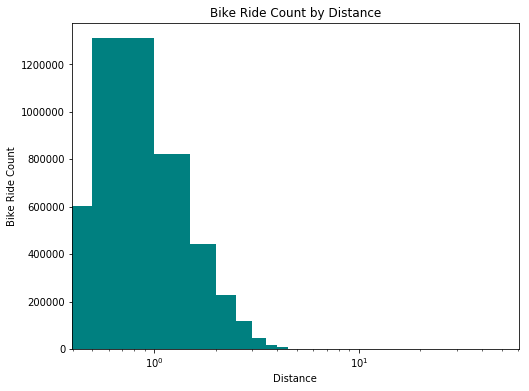

In [183]:
plt.figure(figsize = [8,6])
bin_edges = np.arange(0, bikedata_df_copy['distance'].max()+1, 0.5)
plt.hist(data = bikedata_df_copy, x = 'distance', color = 'teal', bins = bin_edges)
plt.xscale('log')
plt.xlabel('Distance')
plt.ylabel('Bike Ride Count')
plt.title('Bike Ride Count by Distance', fontsize = 12)
#plt.xticks(['0','1','2','3','4','5','6','7','8','9','10','20','30','40','50','60','70','80','90','100'])

> <b> Bike Ride Data by User Type </b>

Text(0.5,1,'Bike Ride Percentage by User Type')

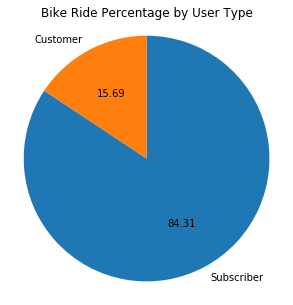

In [184]:
plt.figure(figsize = [8,5])
sorted_counts = bikedata_df_copy['user_type'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90,
        counterclock = False, autopct = '%.2f')
plt.axis('square')
plt.title('Bike Ride Percentage by User Type', fontsize = 12)

We observe that most users are subscribers and a small percentage of users are customers since subscribing to Bay Wheels Service works out cheaper than paying for individual bike rides. 

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The distributions for most of the variables of interest were normal and followed the trends that we expected. Most bike rides were taken by adults heading to work/school on a weekday around 8-9am in the morning and returning from work around 5-6pm in the evening. Most bike rides were taken by Males as opposed to Females.<br>
We did see an unusual spike for age at 0 years. However this represented the bike rides for which member_birth_year was not available, so we chose to ignore it.<br>
The distribution for distance covered by bike rides was concentrated between 0 to 10 miles but also had values close to 50 miles. We had to apply the log transformation on the x-axis inorder to visualise the data correctly.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> There were no unusual distributions in the features we investigated. <br>
We did tidy up the data for distance by excluding rows where the start_station_latitude or end_station_latitude == 0.<br>
We extracted year, month, day and hour time part from the start_time variable in order to visualize data based on various time components.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

> <b> Bike Ride Data by Month and User_Type </b>

([<matplotlib.axis.XTick at 0x1a79dc9d50>,
 <a list of 12 Text xticklabel objects>)

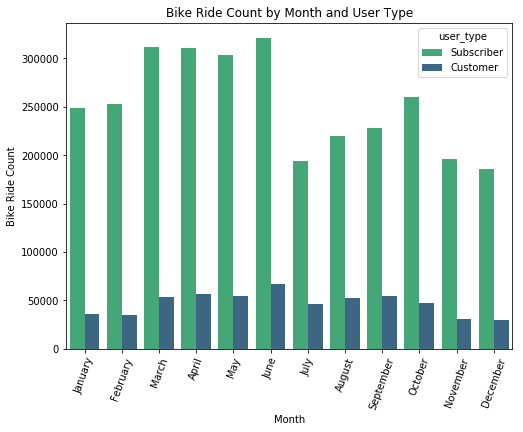

In [185]:
plt.figure(figsize = [8,6])
sb.countplot(data = bikedata_df_copy, x = 'month',hue = 'user_type',palette = 'viridis_r')
plt.xlabel('Month')
plt.ylabel('Bike Ride Count')
plt.title('Bike Ride Count by Month and User Type', fontsize = 12)
plt.xticks(np.arange(0,12,1),['January','February','March','April','May','June','July','August','September','October','November','December'], rotation = 70)


> <b> Bike Ride Data by Weekday and User_Type

([<matplotlib.axis.XTick at 0x1a7aec5850>,
 <a list of 7 Text xticklabel objects>)

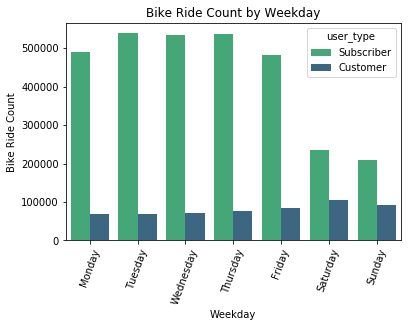

In [186]:
sb.countplot(data = bikedata_df_copy, x = 'weekday',hue = 'user_type', palette = 'viridis_r')
plt.xlabel('Weekday')
plt.ylabel('Bike Ride Count')
plt.title('Bike Ride Count by Weekday', fontsize = 12)
plt.xticks(np.arange(0,7,1),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation = 70)


We observe that more subscriber take bike rides during the weekdays, while customers take the highest number of rides on Saturday and Sunday. This shows that people who subscribe to the bike service usually do so when they plan to bike to work or use it for commuting. Customers usually use the bike rides for leisure purposes on the weekend or are tourists who take a random bike ride

> <b> Bike Ride Data by Hour of the Day and User_Type </b>

([<matplotlib.axis.XTick at 0x1a7b994c90>,
 <a list of 24 Text xticklabel objects>)

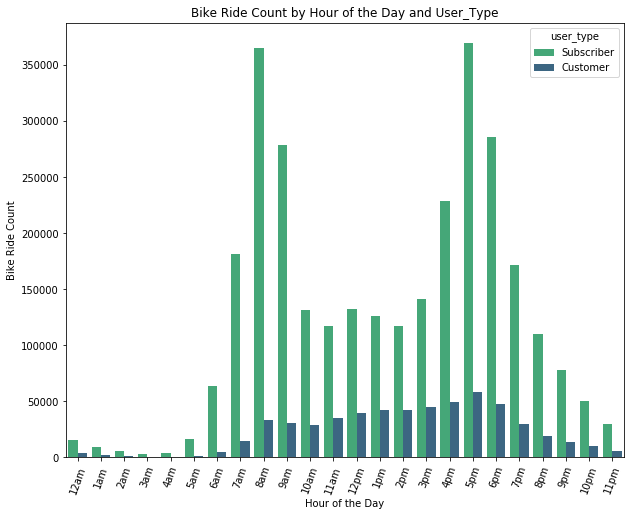

In [187]:
plt.figure(figsize = [10,8])
sb.countplot(data = bikedata_df_copy, x = 'hour',hue = 'user_type', palette = 'viridis_r')
plt.xlabel('Hour of the Day')
plt.ylabel('Bike Ride Count')
plt.title('Bike Ride Count by Hour of the Day and User_Type', fontsize = 12)
plt.xticks(np.arange(0,24,1),['12am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm'], rotation = 70)


Most subscribers complete their bike rides between 8-9am and 5-6pm. However customers completed most of their bike rides around 5pm closely followed by 4 and 6pm.

> <b> Distance of bike rides by User Type </b>

In [188]:
# We convert the duration in seconds to duration in minutes.
bikedata_df_copy['duration_min'] = bikedata_df_copy['duration_sec']/60

In [189]:
bikedata_df_copy['duration_min'].describe(percentiles = [.99])

count    3.594926e+06
mean     1.448711e+01
std      4.031727e+01
min      1.000000e+00
50%      9.333333e+00
99%      9.544583e+01
max      1.439483e+03
Name: duration_min, dtype: float64

In [190]:
# Since 99% of the data lies below 9.54 mins, we exclude data byond that values.
bikedata_df_copy = bikedata_df_copy.query('duration_min <= 95.44')

Text(0.5,1,'Bike Ride Data by Duration and User Type')

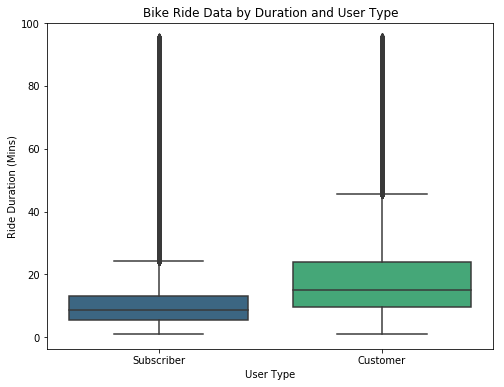

In [239]:
plt.figure(figsize = [8,6])
sb.boxplot(data = bikedata_df_copy, x = 'user_type', y = 'duration_min', palette = 'viridis')
plt.xlabel('User Type')
plt.ylabel('Ride Duration (Mins)')
plt.title('Bike Ride Data by Duration and User Type')

From the visualization, we can observe that Customers usually have longer ride times than Subscribers. We can infer that Customer take rides for leisure or during vacations which can be longer while Subscribers prefer shorter rides for commuting everyday in the week.

> <b> Bike Ride Duration By Member Age </b>

Text(0.5,1,'Bike Ride Duration By Member Age')

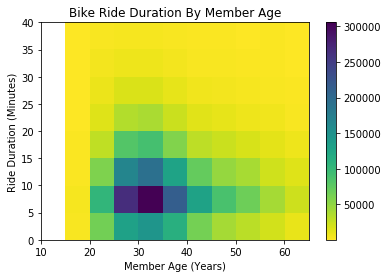

In [226]:
bins_x = np.arange(10, 65+1, 5)
bins_y = np.arange(0, 45, 5)
plt.hist2d(data = bikedata_df_copy, x = 'age', y = 'duration_min',
           bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 0.5)
plt.colorbar()
plt.xlabel('Member Age (Years)')
plt.ylabel('Ride Duration (Minutes)')
plt.title('Bike Ride Duration By Member Age')


We observe that most rides are taken by member between 30-35 years of age and these rise last between 5-10 minutes

> <b> Member Age Data by User Type </b>

Text(0.5,1,'Member Age by User Type')

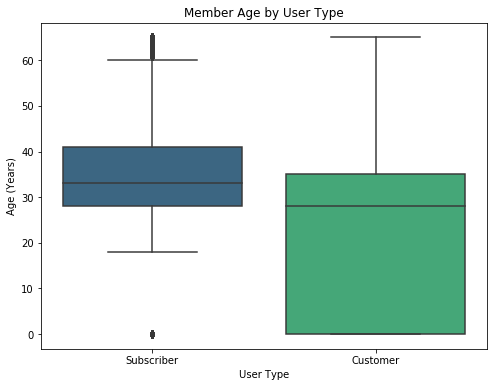

In [242]:
plt.figure(figsize = [8,6])
sb.boxplot(data = bikedata_df_copy, x = 'user_type', y = 'age', palette = 'viridis')
plt.xlabel('User Type')
plt.ylabel('Age (Years)')
plt.title('Member Age by User Type')

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> We observed that Customers and Subscribers had different patterns of completing rides in the day. While Subscribers took more rides in the morning between 8-9am and evening between 5-6pm, Customers took more rides around 5pm in the evening which reduced tapering away towards the morning.  Another intersting fact that showed up was that Customers took more rides over the weekend while Subscribers took rides on the weekday like Monday to Friday. This shows Customer and Subscribers have distinctly different reasons for taking rides. We observe that customers usually have longer ride durations that subscribers.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

>We observed that the age distribution for Customer User type is quite varied and spread out but there is a larger population of customers below the median age value. The median age for Customers is below 30 years. Subscriber on the otther end have a small age group of people with median age value for this group being slightly above 30 years old.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

> <b> We plot Bike Ride Count By User Type against Different Age Groups using Age variable </b>

In [250]:
# We bin the age variable into age groups using the cut() function
bikedata_df_copy['age_group'] = pd.cut(x=bikedata_df_copy['age'], bins=[0, 9, 19, 29, 39, 49, 59, 65], labels=['0-9years', '10-19years', '20-29', '30-39','40-49','50-59','60-65'])

Text(-21.325,0.5,'Bike Ride Count')

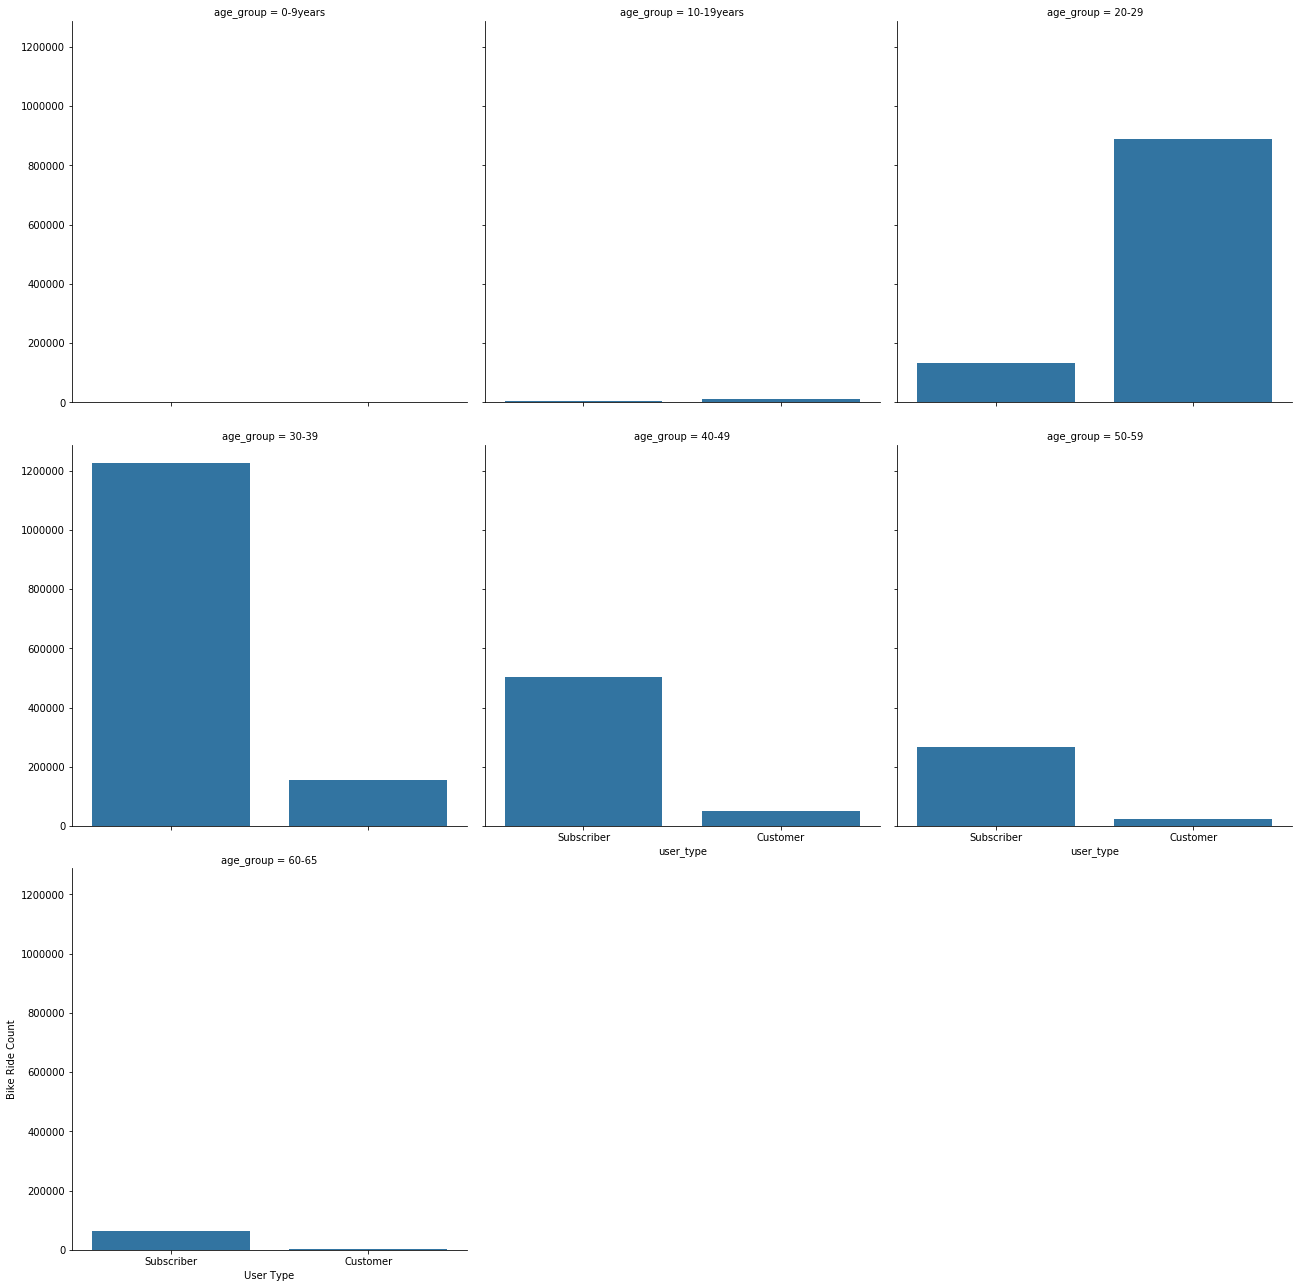

In [255]:
g = sb.FacetGrid(data = bikedata_df_copy, col = 'age_group', height = 6, col_wrap = 3)
g.map(sb.countplot, 'user_type')
plt.xlabel('User Type')
plt.ylabel('Bike Ride Count')

We observe that most Customers are in the age group of 20-29 years while most Subscribers are in the age group of 30-39 years. This can be used while targetting membership options to certain individuals.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!